## LightGBM

In [1]:
import time
import gc
import random
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
import lightgbm as lgb

df = pd.read_csv('train_avito.csv', parse_dates = ['activation_date'])
df['year'] = df['activation_date'].dt.year
df['day_of_year'] = df['activation_date'].dt.dayofyear
df['weekday'] = df['activation_date'].dt.weekday
df['week_of_year'] = df['activation_date'].dt.week
df['day_of_month'] = df['activation_date'].dt.day
df['quarter'] = df['activation_date'].dt.quarter

df.drop('activation_date', axis=1, inplace=True)

In [3]:
df.drop('image', axis=1, inplace=True)

In [4]:
y = df['deal_probability'].values

In [5]:
df.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,item_seq_number,user_type,image_top_1,deal_probability,year,day_of_year,weekday,week_of_year,day_of_month,quarter
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2,Private,1008.0,0.12789,2017,87,1,13,28,1
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,19,Private,692.0,0.00000,2017,85,6,12,26,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,9,Private,3032.0,0.43177,2017,79,0,12,20,1


In [6]:
categorical = ["user_id", "region","city", "parent_category_name", "category_name", "user_type", "image_top_1", "param_1", "param_2", "param_3"]
# Fill NA values for image_top_1 with -1
df["image_top_1"].fillna(-1, inplace=True)

label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna("unknown")
    df[col] = label_encoder.fit_transform(df[col].astype(str))

In [7]:
df["price"].fillna(df.price.median(), inplace=True)
df["price"] = np.log1p(df["price"])

In [9]:
df.drop(['item_id', 'title', 'description'], axis=1, inplace=True)
X = df.loc[:, df.columns != 'deal_probability']

In [10]:
feature_names = X.columns.tolist()
print("Number of featues: ", len(feature_names))

Number of featues:  18


### lightGBM model training

In [11]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)
    
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=feature_names,
                categorical_feature = categorical)

44

In [13]:
lgb_clf = lgb.train(
    params,
    lgtrain,
    num_iterations=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=500,
    verbose_eval=500
)
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_valid, lgb_clf.predict(X_valid))))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 0.219561	valid's rmse: 0.224314
[1000]	train's rmse: 0.216259	valid's rmse: 0.223433
[1500]	train's rmse: 0.214056	valid's rmse: 0.223106
[2000]	train's rmse: 0.212158	valid's rmse: 0.22292
[2500]	train's rmse: 0.210293	valid's rmse: 0.22278
[3000]	train's rmse: 0.208684	valid's rmse: 0.222705
[3500]	train's rmse: 0.207132	valid's rmse: 0.222644
[4000]	train's rmse: 0.205718	valid's rmse: 0.222613
[4500]	train's rmse: 0.204391	valid's rmse: 0.222597
Early stopping, best iteration is:
[4345]	train's rmse: 0.204802	valid's rmse: 0.222595
RMSE of the validation set: 0.222595150292


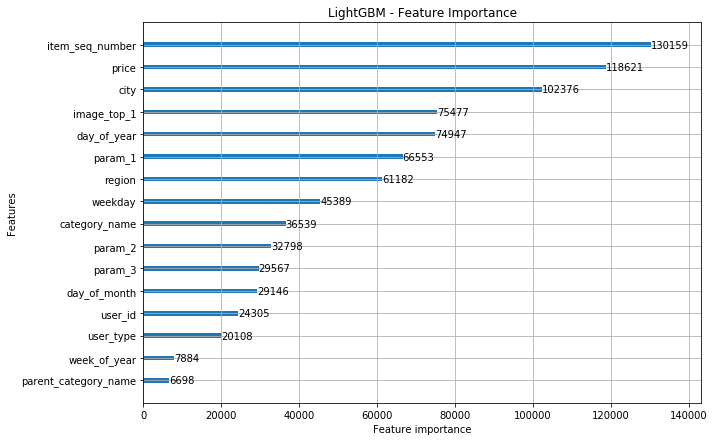

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");